In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import xgboost
import warnings
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LogisticRegression as LR
TRAINING_DATA_PATH = '/home/suhas/Downloads/D1_Project_train.csv'
TEST_DATA_PATH = '/home/suhas/Downloads/D1_Project_test.csv'

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Table of contents: 

1. State assumptions
2. Basic data profiling: understanding the data
3. Preparing the data for model fitting
4. Fitting and evaluating a model (Gradient Boosted Decision Tree)
   - a. Decide what loss function to optimize, and describe how we split the training data into insample and validation. 
   - b. Create helper functions for preparing data, fitting models and evaluating models.  
   - c. Feature attribution analysis
   - d. Benchmark against a simple linear model
5. Opening the outsample: evaluate on the provided test data
6. Further refinements: things worth trying if we had more time. 

# 1. Assumptions

Assumptions: In this section, we state the assumptions made during this exercise. 

- We assume that we do not have access to the timestamp in each row of data. We make this assumption because we found that none of the columns were ordered in non-decreasing order and the FAQ mentions that the rows are time-ordered.
- Based on profiling (Section 2 below), we take it that the dataset corresponds to a single instrument and that the test data follows the training data file in time.

# 2. Basic data profiling

Objectives: 

1. Check which if any predictors are categorical
2. Which predictors are missing data
3. Plot the distribution of each predictor in training and test sets to check for a rough match
4. Look for nonstationarity in predictors. 
5. Look for clues as to whether this entire dataset pertains to a single instrument
6. Look for whether there is a column that might be a timestamp (look for columns that are non decreasing in value)
7. Examine distribution of the target
8. Look for outliers in the predictors and the target

In [2]:
def get_data(datasetType):
    assert datasetType in ['train','test']
    if datasetType == 'train': 
        return pd.read_csv(TRAINING_DATA_PATH)
    if datasetType == 'test':
        return pd.read_csv(TEST_DATA_PATH) 

In [3]:
df = get_data('train')
dftest = get_data('test')

In [4]:
print("Number of data points in training data: ", len(df))
print("Number of data points in provided test data: ", len(dftest))
print("Number of columns in dataframe:", len(df.columns))
print("Column names:", df.columns)
print("Do both datasets have identical column names: ", set(df.columns) == set(dftest.columns))

Number of data points in training data:  90000
Number of data points in provided test data:  19707
Number of columns in dataframe: 68
Column names: Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '63', '64', '65', 'TARGET'],
      dtype='object')
Do both datasets have identical column names:  True


In [5]:
df.rename(columns = {df.columns[0]: 'ind'}, inplace = True)

Check for categorical features by counting the number of unique values in each column

In [6]:
d = []
for i in range(66):
    d.append([len(set(df[str(i)])), len(set(df[str(i)]))/len(df), i])
d = sorted(d)
pd.DataFrame(d, columns = ['num_distinct_values','fraction_of_numRows','predictor']).head(20)

num_distinct_values  fraction_of_numRows  predictor
0                    23             0.000256         22
1                    24             0.000267         26
2                    33             0.000367         14
3                    34             0.000378         17
4                    35             0.000389         24
5                    35             0.000389         28
6                    39             0.000433         19
7                    40             0.000444         16
8                    40             0.000444         29
9                    41             0.000456         25
10                   45             0.000500         15
11                   46             0.000511         18
12                   56             0.000622         23
13                   58             0.000644         27
14                  210             0.002333          2
15                  213             0.002367          1
16                59259             0.658433          8
17                65635             0.729278         12
18                68203             0.757811          7
19                83892             0.932133         38

From the above, there are 16 predictors that look like they might potentially be categorical because they take on very few values  (between 23 - 213 distinct values, in 90000 rows). However, when we profile the distributions, we see that these values are floats, which suggests that they encode numerical rather than categorical data. We do not convert these predictors to on-hot encoded versions but leave them as is. 

Next, we tabulate the simple correlation between each x and TARGET 

Text(0.5, 1.0, 'Hist of univariate corrs')

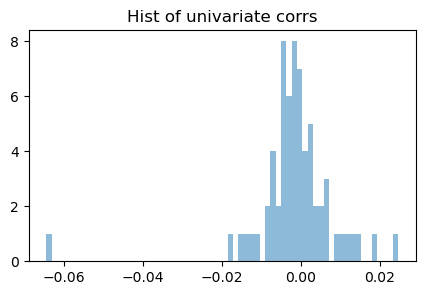

In [7]:
plt.figure(figsize = (5,3))
dfcorrs = pd.DataFrame([(i, np.corrcoef(df.TARGET, df[str(i)])[0][1]) for i in range(66)])
tstats = []
Y = np.array(df.TARGET)
Y = sm.add_constant(Y, prepend=False)
for i in range(66):
    X = np.array(df[str(i)])
    mod = sm.OLS(X, Y)
    res = mod.fit()
    tstat = res.tvalues[0]
    tstats.append(tstat)
dfcorrs.columns = ['var', 'corr']
dfcorrs['tstat'] = tstats
dfcorrs['abs_tstat'] = np.abs(dfcorrs.tstat)
dfcorrs = dfcorrs.sort_values('abs_tstat', ascending = False)
plt.hist(dfcorrs['corr'], 66, alpha = 0.5);
plt.title('Hist of univariate corrs')

In [8]:
dfcorrs.head(10)

var      corr      tstat  abs_tstat
4     4 -0.064575 -19.412726  19.412726
59   59  0.024762   7.430810   7.430810
61   61  0.018988   5.697374   5.697374
24   24 -0.017271  -5.182061   5.182061
25   25 -0.014964  -4.489771   4.489771
60   60  0.014802   4.441180   4.441180
22   22 -0.013802  -4.140880   4.140880
9     9 -0.012949  -3.885130   3.885130
26   26  0.012598   3.779607   3.779607
45   45  0.012439   3.732070   3.732070

There seem to be several variables with strong linear correlations, in particular predictor 4 has a strong negative corr with the TARGET

Next, we look for missing data in any of the predictors

In [9]:
for i in range(66):
    missing_fraction = len(df[df[str(i)].isnull()])/len(df)
    if missing_fraction > 0: 
        print('Variable', i, 'missing in', missing_fraction*100, '% of the rows')

There is no missing values in the predictors!

Next, we plot the distribution of each predictor as a density plot, from the training dataset (blue), and again from the test dataset (orange). This is to visually see if their distributions roughly match, and also to visually catch predictors that might have outliers. 

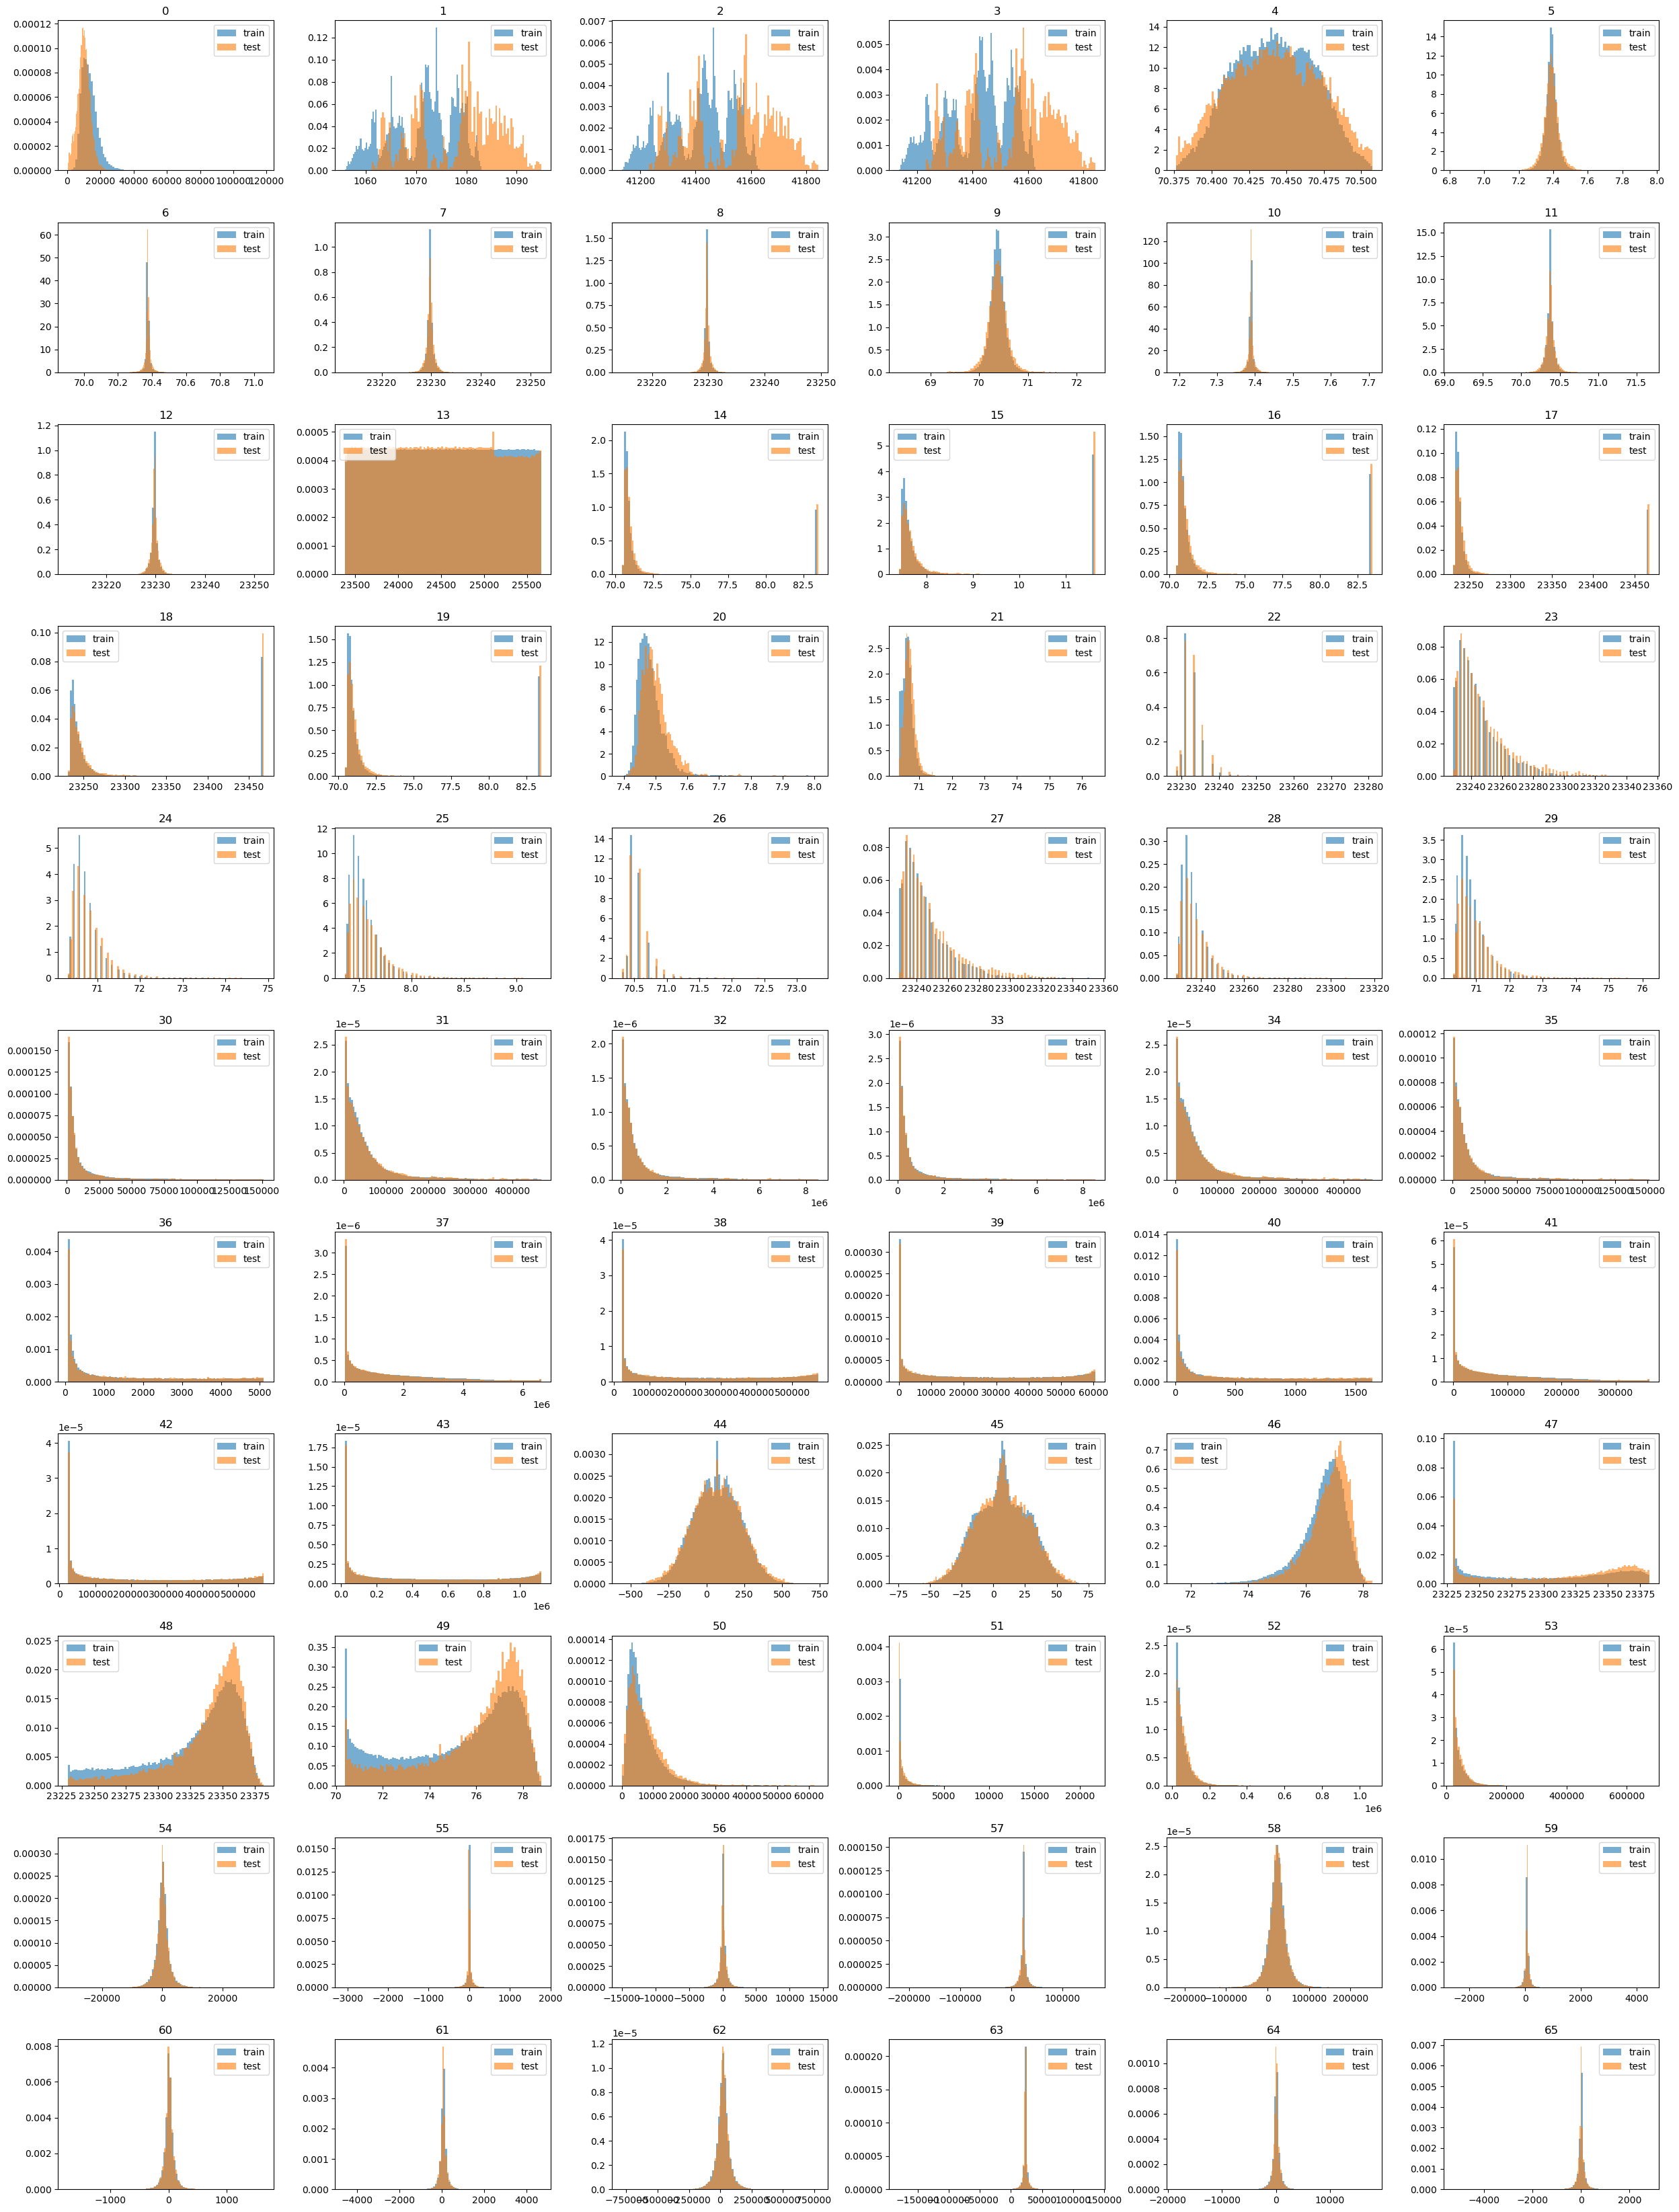

In [10]:
fig, ax = plt.subplots(11, 6, figsize = (25, 33))
c = 0
for i in range(66):
    c += 1
    plt.subplot(11,6,c)
    plt.hist(df[str(i)], 100, alpha = 0.6, density = True);
    plt.hist(dftest[str(i)], 100, alpha = 0.6, density = True);
    plt.title(str(i))
    plt.legend(['train','test'])
plt.tight_layout()

Some observations from the above plots: 

- The Histogram plots for predictors 1, 2 and 3 show that their distributions are quite different between training and test sets. This raises a concern about the staionarity of these features. In general it is a bad idea to include non -stationary features in a model because their out-sample values can be different from their in-sample values, and therefore might make the model behave in unexpected ways. 
- There are also other predictors with smaller mismatches in distributions e.g. predictor 49. 
- Some predictors have low cardinality of values -- e.g. 22-29. as we have previously seen.

Let us try plotting the time series for predictors 1,2 and 3 (under the assumption that there is only a single instrument in the dataset so rows would correspond to the same instrument, ordered by time.

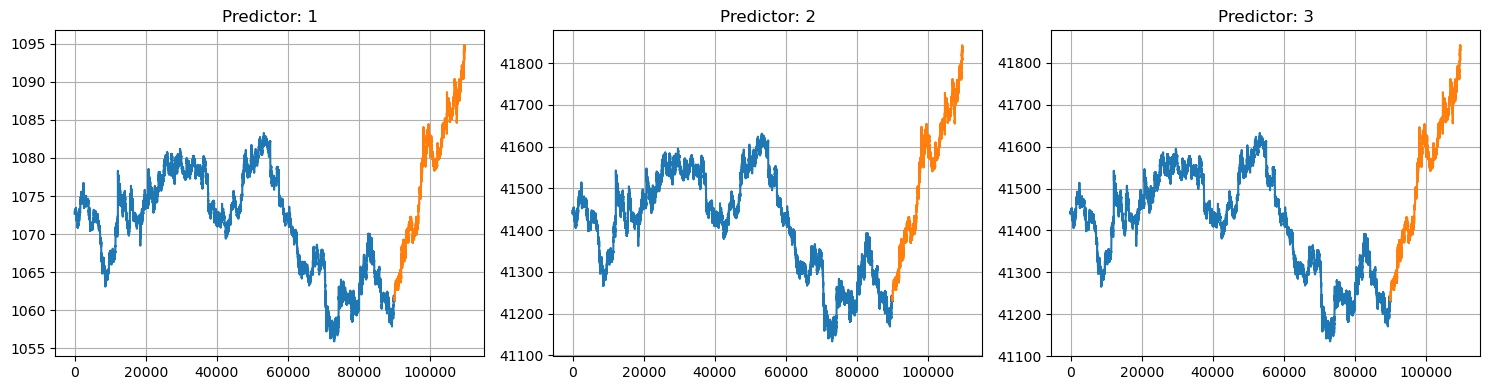

In [11]:
fig, ax = plt.subplots(1,3,figsize = (15, 4))
for k in range(1,4):
    i = str(k)
    plt.subplot(1,3,k)
    dfnew = pd.concat([df[[i]], dftest[[i]]]).reset_index()
    plt.plot((dfnew[i].head(len(df))))
    plt.plot((dfnew[i].tail(len(dftest))))
    plt.grid()
    plt.title('Predictor: ' + i)
plt.tight_layout()

These look like price-like time series which would explain why their distribution is different from training to test data (price is not a stationary quantity). 
The above provides some visual evidence that the dataset is for a single instrument, and the test data follows the trianing data in time

We dig a bit further by trying to plot the histogram of predictor 1 for different parts of training data, in chunks of 20000 rows each. 

/home/suhas/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


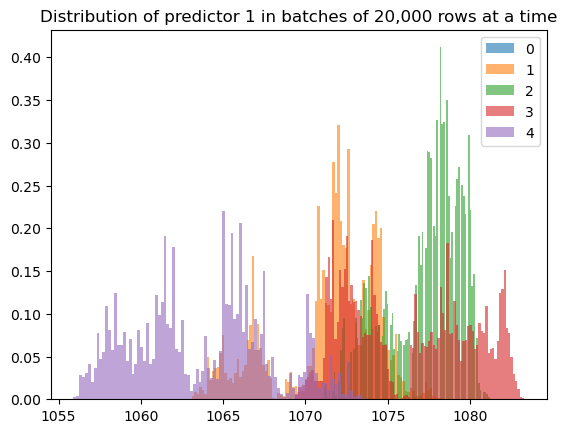

In [12]:
i = 1
chunksize = 20000
for k in range(5):
    plt.hist(df[str(i)].head(chunksize * k).tail(chunksize), 100, alpha = 0.6, density = True);
plt.title('Distribution of predictor 1 in batches of 20,000 rows at a time')
plt.legend(list(range(5)))

We see that the distribution moves around quite a bit as a function of time. In general it is not a great idea to have non-stationary predictors like price 

So we should try to (1) Identify all nonstationary predictors, and (2) either transform them in some way to make them stationary, or discard them.

We identify potentially nonstationary predictors by creating batches of 15000 contiguous rows starting from the top, and measuring the mean and stdDev of each batch for each predictor. If the difference (max(batch mean) - min(batch mean))/(min(StdDev among all batches)) is > 2 then we deem the variable to be potentially nonstationary. Intuitively this measures whether the means of the chunks differ by a large amount compared to the stdDev in any given chunk. 

In [13]:
df['batch'] = np.floor(df.ind / 15000)

In [14]:
warnings.filterwarnings('ignore')
results = []
for i in range(66):
    dfstats = df[['batch',str(i)]].groupby('batch').agg({np.mean, np.std}).reset_index()
    ratio = (np.max(dfstats[str(i)]['mean']) - np.min(dfstats[str(i)]['mean']))/np.min(dfstats[str(i)]['std'])
    results.append([ratio, i])
dfstationarity = pd.DataFrame(results)
dfstationarity.columns = ['ratio','predictor']
dfstationarity = dfstationarity.sort_values('ratio', ascending = False)

In [15]:
dfstationarity.head(20)

ratio  predictor
3   5.558129          3
1   5.557851          1
2   5.556199          2
46  1.035309         46
0   0.861213          0
50  0.782757         50
48  0.739017         48
20  0.699647         20
49  0.642390         49
21  0.592907         21
47  0.484295         47
52  0.469777         52
53  0.391692         53
28  0.298026         28
24  0.294685         24
26  0.294448         26
22  0.289098         22
51  0.276496         51
29  0.262508         29
25  0.259862         25

Predictors 1,2, and 3 seems to be the worst offenders, using our metric above. 

Next we plot the first 500 time steps of each predictor to get a sense of each predictor

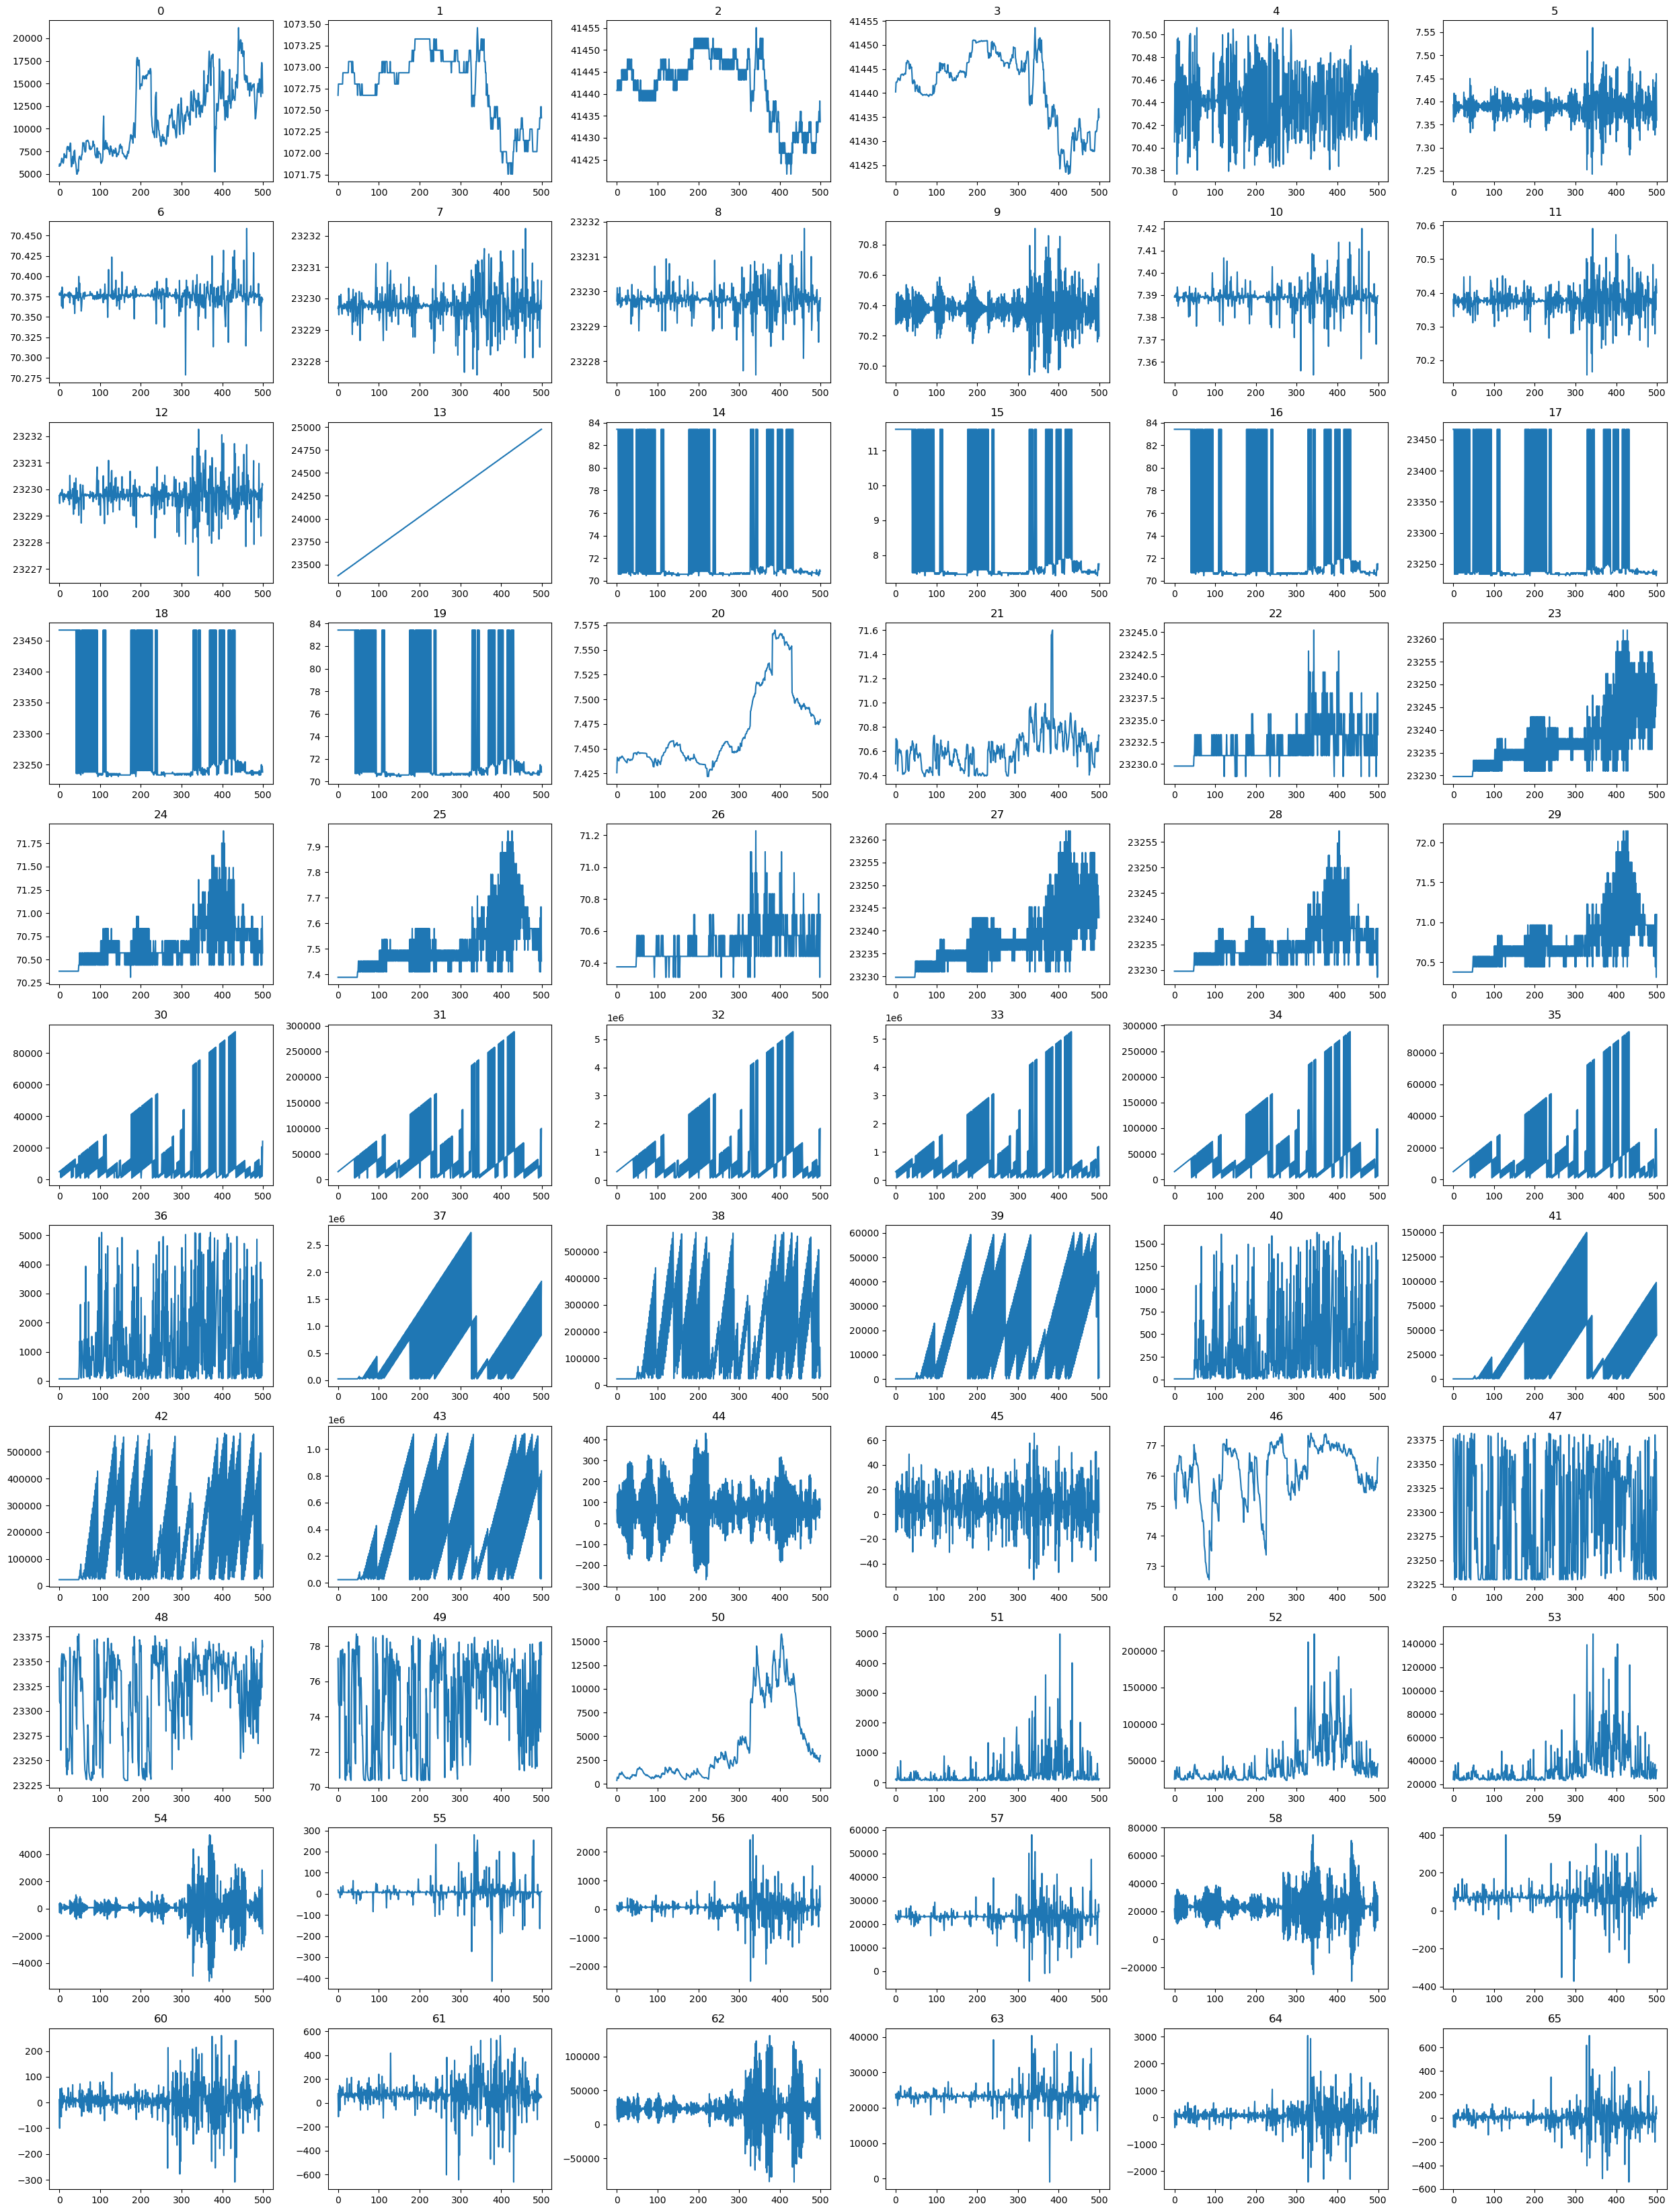

In [16]:
fig, ax = plt.subplots(11, 6, figsize = (25, 33))
c = 0
for i in range(66):
    c += 1
    plt.subplot(11,6,c)
    plt.plot(df[str(i)].head(500));
    plt.title(str(i))
plt.tight_layout()

Some observations based on the above plots: 

1. Predictors 1,2,3 looks price-like as we have seen before.
2. Predictor 13 seems linear above - upon plotting a larger sampling we find that it has a very basic sawtooth pattern that repeats indifinitely. It may be related to a clock, or a time since some even has occured. Given the regular pattern, the utility of this predictor seems questionable. 
3. Some predictors like 14, 15 etc. seem to have multiple floating point values but look like there really are only 2 different values: high and low. We could consider encoding these as categorical variables (high/low) -- but if we chose to use tree based methods then the tree would also be able to split based on whether such a predictor is high or low, and therefore an explicit coding into high/low or a categorical/one hot coding might not be needed if we use trees. 
4. Some features appear to be related to time as they repeatedly increase linearly and then drop down in value -- example feature 30-35.

Text(0.5, 1.0, 'Predictor 13 is simply a repeating sawtooth\n First 15000 samples')

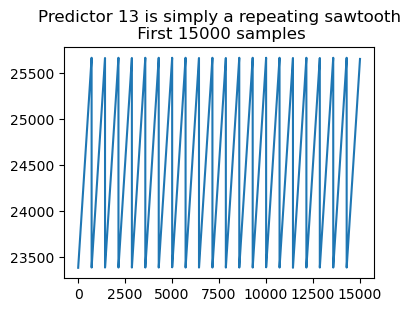

In [20]:
plt.figure(figsize = (4,3))
plt.plot(df['13'].head(15000));
plt.title("Predictor 13 is simply a repeating sawtooth\n First 15000 samples")

Let us compute and plot the pairwise correaltion matrix of predictors


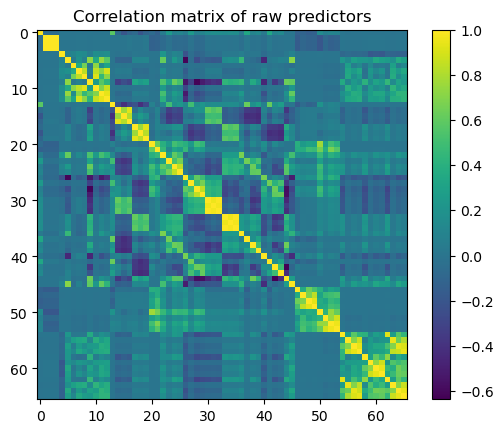

In [21]:
K = np.corrcoef(df[[str(i) for i in range(66)]].T)
plt.imshow(K, interpolation = 'nearest');
plt.title("Correlation matrix of raw predictors")
plt.colorbar()

We see that there a some groups of correlated predictors

Next we check: Which if any predictors are in increasing order (and therefore could be timestamps)

In [22]:
for i in range(66):
    l = list(df[str(i)])
    if l == sorted(l):
        print(i)

None of the predictors seem to be timestamps

Finally, let us examine the distribution of the TARGET variable, to see if it has some large outliers. Outliers in the TARGET can be problematic when fitting tree-based models because they can over emphasize some training data points. Outliers in predictors are not as problematic because trees split on feature values (in contrast they predict using averages of TARGET values lying in leaves). 

Text(0.5, 1.0, 'Histogram of TARGET \n Has some extreme values that could affect a downstream model')

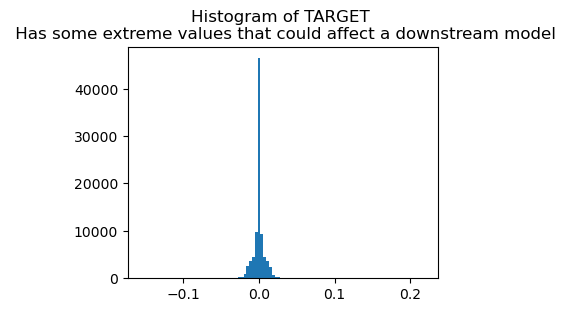

In [23]:
plt.figure( figsize = (4, 3))
plt.hist(df.TARGET, 100);
plt.title("Histogram of TARGET \n Has some extreme values that could affect a downstream model")

We see what the TARGET distribution would look like if we clipped to 0.5% and 99.5%

In [25]:
[lower, upper] = np.percentile(df.TARGET, [0.5,99.5])
lower, upper

(-0.02667117297, 0.025779793500000103)

Text(0.5, 1.0, 'Histogram of TARGET -- after clipping')

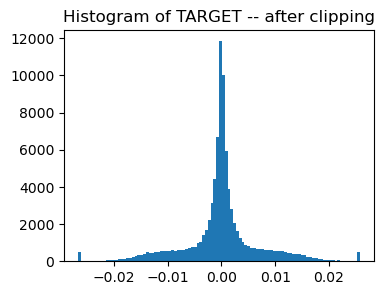

In [26]:
plt.figure( figsize = (4, 3))
plt.hist(df.TARGET.clip(lower = lower, upper = upper), 100);
plt.title("Histogram of TARGET -- after clipping")

What fraction of the TARGETs are positive in training and test sets? 

In [28]:
len(df[df.TARGET > 0])/len(df), len(dftest[dftest.TARGET > 0])/len(dftest)

(0.5006333333333334, 0.5005835489927437)

Ok, so each dataset has roughly 50% of the TARGET values positive.

# 3. Prepare the dataset for training: cleaning and transformations

We will make the following cleaning and transformations: 

1. We clip the TARGET varaible to 0.5% and 99.5% to prevent lar outliers from affecting a downstream model too much. We do this only in in-sample portion of the training data and not the validation sample (as we will describe below, we split the training set into 2/3rd for in-sample, used for training and 1/3rd validation, used for validation). 

2. We remove predictor 13. Its regular repeating makes it a questionable predictor. Having useless predictors in the input set of predictors can pollute a downstream model, when the amount of training data is finite. 

3. For features 1,2,3 (which look like prices), we drop them entirely. An alternative would be replacing these predictors with x - expMovingAverage(x, halfLife = 100 pts). This is to induce a stationarity transformation. This is an approximate transformation because we don't have access to the timestamps, so we don't really know how far back in time we are looking. In practice, when fitting a model downstream, we simply drop predictors 1,2 and 3, because we would not be able to compute the modified features the first few data points in the test set (unless we assumed that the test data immediately follows the training data, which may not necessarily be true). 
   
4. Similarly, for all other features, we could consider computing a 'rolling' zscore transformations to create new features. These might be useful but in practice we don't use these features becaues we don't quite know how far back in time we are looking when we look back a fixed number of rows to compute a rolling mean and stdDev, and also because we wouldn't be able to compute these features for the first few data points in the test datasets (unless we assumed that the test data immediately follows the training data, which may not necessarily be true).



In [29]:
features_to_replace = [1,2,3]
features_to_append = [0] + list(range(4, 66))
features_to_delete = ['1', '2', '3', '13']

In [30]:
for feature in features_to_replace: 
    df[str(feature) + '_new'] = df[str(feature)] - (df[str(feature)].ewm(halflife = 100).mean())

In [31]:
for feature in features_to_append:
    m = df[str(feature)].rolling(100).mean()
    s = df[str(feature)].rolling(100).std()
    df[str(feature) + '_new'] = (df[str(feature)] - (m))/s

In [32]:
len(df), len(df.dropna())

(90000, 89901)

In [33]:
for f in features_to_delete: 
    del df[f]

In [34]:
predictor_names = [0] + list(range(4, 13)) + list(range(14, 66))
predictor_names = list(map(str, predictor_names))
predictor_names = predictor_names + list(map(lambda x: (x) + '_new', predictor_names))
predictor_names += ['1_new', '2_new', '3_new']

In [35]:
len(predictor_names)

127

Even though we compute these modified features and save them to disk below, we do not use them downstream (because we are not confident that we can correct compute these modified features for every row in the provided test set)

In [36]:
df[predictor_names + ['TARGET']].to_csv('/home/suhas/research/optiver/modified_training_data.csv', index = False)

In [37]:
df[predictor_names + ['TARGET']].head()

0          4         5          6            7            8  \
0  5874.524387  70.405148  7.392780  70.377281  23229.69262  23229.72655   
1  6124.154099  70.456758  7.356050  70.379576  23229.76020  23230.10472   
2  5905.732593  70.422472  7.417794  70.376448  23229.48142  23229.61008   
3  6029.325221  70.458533  7.366031  70.379221  23230.08433  23229.87971   
4  6142.360146  70.413623  7.411287  70.376788  23229.70975  23229.82255   

           9        10         11           12  ...  60_new  61_new  62_new  \
0  70.378864  7.389173  70.380160  23229.76782  ...     NaN     NaN     NaN   
1  70.273618  7.389813  70.329906  23229.46908  ...     NaN     NaN     NaN   
2  70.474265  7.388979  70.397301  23229.83396  ...     NaN     NaN     NaN   
3  70.288944  7.390120  70.370247  23229.81662  ...     NaN     NaN     NaN   
4  70.467206  7.389910  70.386986  23229.87603  ...     NaN     NaN     NaN   

   63_new  64_new  65_new     1_new     2_new     3_new    TARGET  
0     NaN     NaN     NaN  0.000000  0.000000  0.000000  0.013314  
1     NaN     NaN     NaN  0.065312  0.000000  0.990186 -0.000448  
2     NaN     NaN     NaN  0.043390  1.582131  0.710617  0.000244  
3     NaN     NaN     NaN  0.032430 -0.597414  0.495827 -0.000628  
4     NaN     NaN     NaN  0.025854  1.422273  0.561087  0.003811  

[5 rows x 128 columns]

# 4. Model fitting

#### 4(a) What loss function should we be looking to optimize? 

- The goal is to select a subset of trades in the test set, and maximize the sum(TARGET) on the selected opportunities
- Therefore this is a classification problem where the output is either '1' = select opportunity, or '0' = pass
- However, the labels provided in the dataset are not simply binary, but rather real valued. 
- The objective to maximize is $\sum T_i \hat{y}_i$, where $\hat{y}_i$ is the prediction $\in \{0,1\}$ and $T_i$ is the provided target. 
- We can express this as a weighted binary classification problem, using a per-sample weighted binary cross entropy loss. Here, the weights are the magnitudes of the TARGET variables, the new training labels are the sign (0/1) and the prediction output is a probability that we should trade. In other words, we minimize the weighted log loss: $\sum_i|T_i|[(-y_i \log(p_i)- (1-y_i) \log(1-p_i)]$, where $i$ runs over the training instances, and only one of the two terms is nonzero for any training instance. 
- The above formulation has the following properties: (a) It penalizes an incorrect prediction proportional to the magnitude of the target $|T_i|$ since this affects PNL, and similarly rewards correct predictions proportional to $|T_i|$. (b) It penalizes more confident incorrect predictions and rewards more confident correct predictions (just as plain vanilla cross entropy does). 
- We break up the training set into two parts: the first 2/3rd of the 90k rows is used for model fitting and the latter 1/3rd is used for a validation set. That is, as we change the parameters and hyper-parameters on the training set, we evaluate on the validation set. This helps us tune the params/hyperparmas optimally and avoid overfitting. 
- When we are ready to test the performance of the selected model on the provided test set, we refit the model with the selected parameters on the entire training set of 90k rows. 
- Given this loss, we can easily express this loss in the framework of Gradient Boosted Decision trees (say, using a package like XGBoost), or write a small neural net with this loss function. We choose Gradient Boosted Trees for this exercise because it is relatively easier to train them and they require a shorter time to produce predictive outputs, realtive to a neural net that can require more time to tune properly, deal different input variable scales, and with training convergence. Given more time, and for more realistic problems, it is worth trying to spend time tuning a neural architecture.  
- An alternative approach would be to train a GBDT ensemble using a regression loss. However, doing so would then entail a further step of deciding how to select a subset of trades based on the model predictions (the simplest case would be to select trade opportunites where the model output is > 0). This approach may also work well but it does not allow for end to end optimization -- for this reason, we chose to proceed with the modified (weighted) log loss described above. 

#### 4(b) Create helper functions for model fitting and data loading

In [38]:

def prepare_train_val_data(dfin, predictor_names, train_size):
    assert train_size <=len(dfin)
    [clipLower, clipUpper] = np.percentile(dfin.TARGET.head(train_size), [0.5,99.5])
    X_train = dfin[predictor_names].head(train_size)
    W_train = np.abs(dfin.TARGET.head(train_size).clip(lower = clipLower, upper = clipUpper)) # Clip large weights
    Y_train = list(map(int, (np.sign(dfin.TARGET.head(train_size)) + 1)/2))
    
    val_size = len(dfin) - train_size
    X_val = dfin[predictor_names].tail(val_size)
    Y_val = dfin.TARGET.tail(val_size)
    return X_train, Y_train,W_train, X_val, Y_val
    
def compute_weighted_log_loss(true_classes, target, pred_probs):
    # This computes -1 * Sum w_i * (y_i log pi + (1-y_i log (1-p_i))
    # Where w_i is the magnitude of the TARGET, y_i is either 1 (trade) or 0 (dont trade), and p_i is the predicted probability of 1 (trade) 
    assert len(pred_probs) == len(target) 
    assert len(target) == len(true_classes)
    total_loss = 0
    for i in range(0, len(true_classes)):
        total_loss += -1 * np.abs(np.array(target)[i]) * np.log(pred_probs[i][true_classes[i]])
    return total_loss/len(true_classes)


def fit_xgboost_model(X_train, 
                      Y_train, 
                      W_train, 
                      evaluate_on_val_set = False,
                      X_val = None, 
                      Y_val = None,
                      numTrees = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100], 
                      maxDepths = [4,6,8,10,12], 
                      learningRates = [0.1], 
                      rowSamplings = [0.8],
                      colSamplings = [0.8], 
                      verbose = False):
    results = []
    if evaluate_on_val_set:
            true_classes = np.array(list(map(int, (np.sign(Y_val) + 1)/2)))
    for max_depth in maxDepths:
        for learning_rate in learningRates: 
            for trees in numTrees:        
                for colSampling in colSamplings:
                    for rowSampling in rowSamplings:
                    
                        bst = xgboost.XGBClassifier(n_estimators=trees, 
                                                   max_depth=max_depth, 
                                                   learning_rate=learning_rate, 
                                                   objective='binary:logistic',
                                                   booster='gbtree',
                                                   colsample_bytree = colSampling,
                                                   subsample = rowSampling)
                
                        bst.fit(X_train, Y_train, sample_weight = W_train)
        
                        metrics = [trees, max_depth, learning_rate, colSampling, rowSampling]
                        cols = ['trees','max_depth','lr','colSampling','rowSampling']
                        # Compute training metrics
                        pred_probs_train = bst.predict_proba(X_train)
                        train_weighted_log_loss = compute_weighted_log_loss(Y_train, (np.array(Y_train) * 2 - 1) * np.array(W_train), pred_probs_train)
                        metrics.append(train_weighted_log_loss)
                        cols.append('train_weighted_log_loss')
                        
                        # Compute validation set metrics if needed
                        if evaluate_on_val_set:
                            preds_val = bst.predict(X_val)
                            pred_probs_val = bst.predict_proba(X_val)
                            sum_profit_val = profit(Y_val, preds_val)
                            sharpe_val = sharpe(Y_val, preds_val)
                            trading_fraction = len(preds_val[preds_val == 1])/len(preds_val) # what fraction of opportunies are picked
                            val_weighted_log_loss = compute_weighted_log_loss(true_classes, Y_val, pred_probs_val)
                            metrics.extend([val_weighted_log_loss, sum_profit_val, sharpe_val, trading_fraction])
                            cols.extend(['val_weighted_log_loss', 'sum_profit_val', 'sharpe_val', 'trading_fraction'])
                        if verbose: 
                            print(metrics)
                        results.append(metrics)
    dfresultsClassifierBinary = pd.DataFrame(results)
    dfresultsClassifierBinary.columns = cols
    return dfresultsClassifierBinary


def profit(y, pred):
    pred = np.array(pred)
    y = np.array(y)
    return np.sum(y[pred > 0])

def sharpe(y, pred):
    pred = np.array(pred)
    y = np.array(y)
    y = y[pred > 0]
    m = np.mean(y)
    s = np.std(y)
    return m/s

def plot_results(dfresults):
    lrs = sorted(list(set(dfresults.lr)))
    for lr in lrs:
        fig, ax = plt.subplots(1,3,figsize = (20, 6))
        c = 0
        for metric in ['train_weighted_log_loss','val_weighted_log_loss','sum_profit_val']:
            c += 1
            plt.subplot(1,3,c)
            mds = sorted(list(set(dfresults.max_depth)))
            lrs = sorted(list(set(dfresults.lr)))
            css = sorted(list(set(dfresults.colSampling)))
            rss = sorted(list(set(dfresults.rowSampling)))
            leg = []
            for md in mds:
                    for cs in css:
                        for rs in rss:
                            dftoplot = dfresults[(dfresults.lr == lr) & (dfresults.max_depth == md) & (dfresults.rowSampling == rs) & (dfresults.colSampling == cs)]
                            plt.plot(list(dftoplot.trees), list(dftoplot[metric]), '.-')
            plt.grid()
            plt.title(metric + ', lr=' + str(lr))
    plt.tight_layout()

##### 4(c) We fit model on the original predictors but drop predictors 1,2,3,13

In [39]:
df = get_data('train')
df = df[df.TARGET != 0] # Because we will divide into two classes based on sign of TARGET. This step only drop 2 rows. 
num_training_points = 60000
predictor_names = ['0'] + list(map(str, range(4, 13))) + list(map(str, range(14, 66)))
len(predictor_names), len(df)

(62, 89998)

In [40]:
[X_train, Y_train, W_train, X_val, Y_val] = prepare_train_val_data(df, predictor_names, num_training_points)

In [41]:
len(X_train), len(Y_train), len(W_train), len(X_val), len(Y_val)

(60000, 60000, 60000, 29998, 29998)

In [37]:
dfresults = fit_xgboost_model(X_train, 
                              Y_train, 
                              W_train, 
                              evaluate_on_val_set = True, 
                              X_val = X_val, 
                              Y_val = Y_val, 
                              numTrees = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100], 
                              maxDepths = [4, 6, 8, 10, 12], 
                              learningRates = [0.1, 0.3, 0.7], 
                              colSamplings = [0.2, 0.5, 0.8, 1], 
                              rowSamplings = [0.2, 0.5, 0.8, 1])

In [38]:
dfresults.sort_values('val_weighted_log_loss').head()

trees  max_depth   lr  colSampling  rowSampling  \
606      30          6  0.1          1.0          0.8   
622      40          6  0.1          1.0          0.8   
2202     40         12  0.1          0.8          0.8   
618      40          6  0.1          0.8          0.8   
638      50          6  0.1          1.0          0.8   

      train_weighted_log_loss  val_weighted_log_loss  sum_profit_val  \
606                  0.002648               0.003319       10.823858   
622                  0.002629               0.003320       10.500484   
2202                 0.002618               0.003321       10.254665   
618                  0.002633               0.003321       10.079741   
638                  0.002614               0.003321        9.962490   

      sharpe_val  trading_fraction  
606     0.098732          0.475798  
622     0.094378          0.479265  
2202    0.091923          0.480965  
618     0.089144          0.484066  
638     0.087999          0.484866

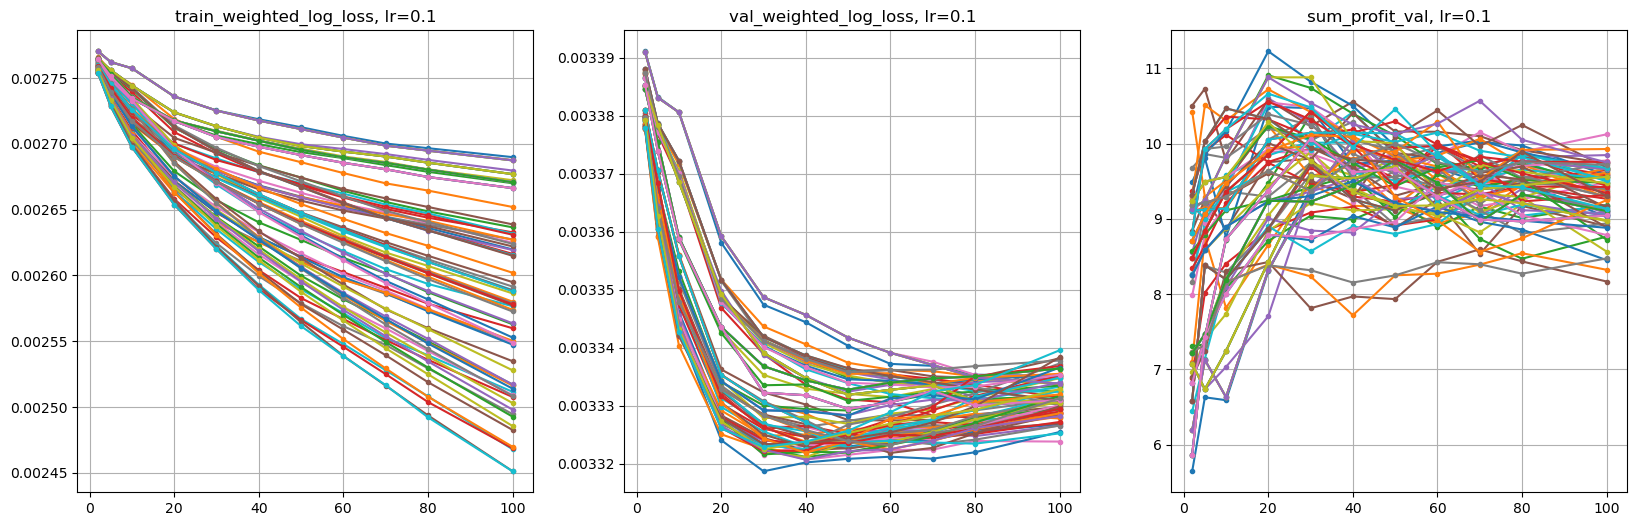

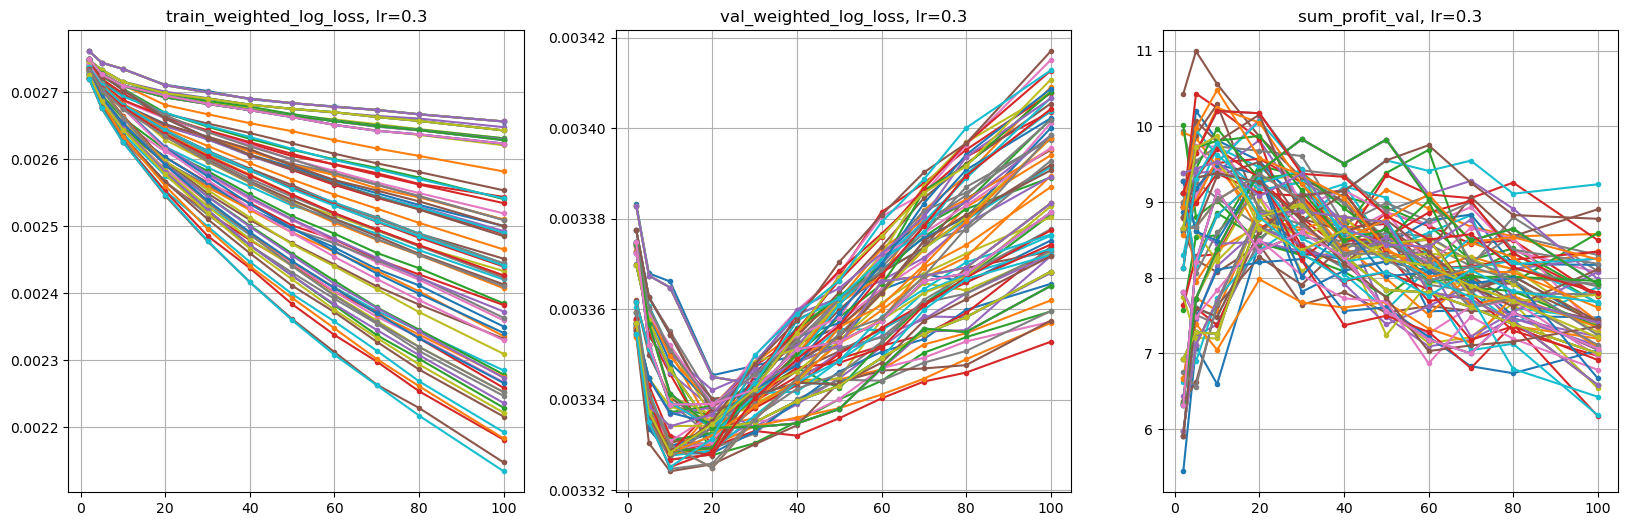

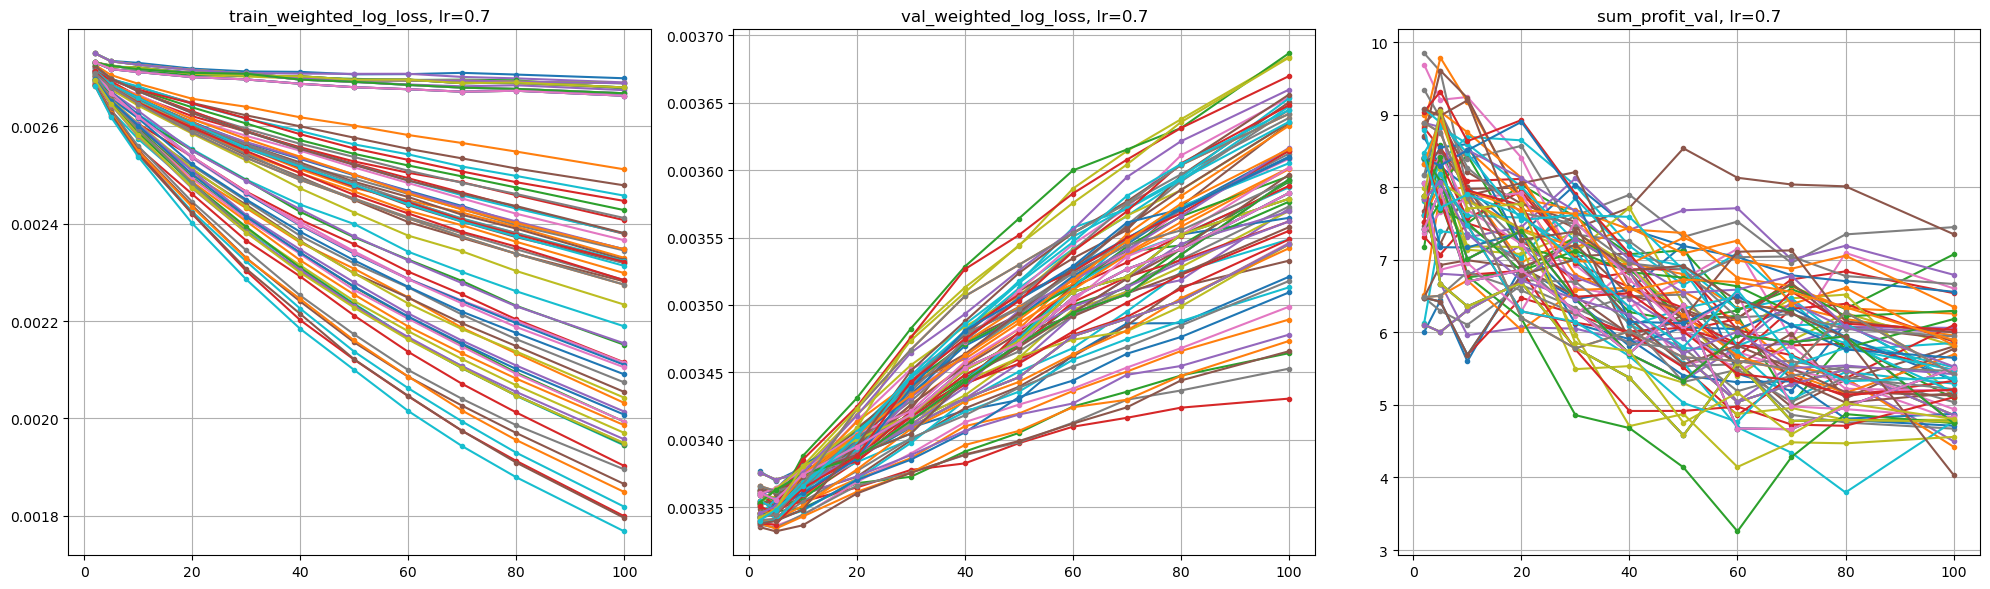

In [39]:
plot_results(dfresults)

As expected, in the above plots we see that training loss continues to descrease as we add more trees but validation loss first decreases and then increases. From the above validation performance, we pick the optimal parameters based on what achieves the smallest validation loss (weighted log loss) and also high sum_profit on the validatin set. Based on this criterion, the optimal parameters we pick are: 

- max_depth = 6
- num_trees = 30
- learning_rate = 0.1
- column_sampling_probability = 1.0
- row_sampling_probability = 0.8


##### 4(d) Feature attribution and refitting

- In this section we examine the SHAP feature attribution for each data point in the validation set. 
- We also compute the attgregate SHAP score per feature to highlight which features contribute most to the final predictions.
- The per-datapoint SHAP values per feature in the validation set are then used to measure the predictive quality of each feature

In [42]:
# Fit the model with selected hyperparams
bst = xgboost.XGBClassifier(n_estimators=30, 
                           max_depth=6, 
                           learning_rate=0.1, 
                           objective='binary:logistic',
                           booster='gbtree',
                           colsample_bytree = 1.0,
                           subsample = 0.8)
        
bst.fit(X_train, Y_train, sample_weight = W_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
model = bst.get_booster()
SHAP_val = model.predict(xgboost.DMatrix(X_val), pred_contribs=True)
SHAP_aggregate_val = abs(SHAP_val.T[0:-1]).mean(axis = 1)
len(SHAP_val), len(SHAP_aggregate_val)

(29998, 62)

Text(0.5, 1.0, 'Aggregate SHAP scores per feature')

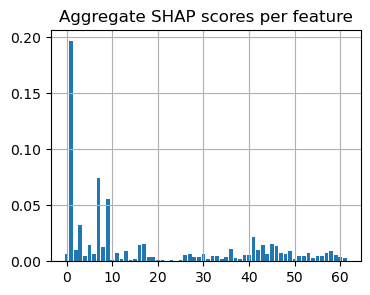

In [47]:
# Plot the aggregate shap scores across features
plt.figure(figsize = (4,3))
plt.bar(np.arange(0, len(SHAP_aggregate_val)), SHAP_aggregate_val);
plt.grid()
plt.title("Aggregate SHAP scores per feature")

In [49]:
dfSHAP = pd.DataFrame(SHAP_aggregate_val)
dfSHAP.columns = ['mean_abs_SHAP']
dfSHAP['predictor'] = predictor_names
dfSHAP.sort_values('mean_abs_SHAP', ascending = False).head()

mean_abs_SHAP predictor
1        0.196352         4
7        0.073902        10
9        0.055313        12
3        0.032361         6
41       0.021680        45

The features with greatest contribution to the predictions are: 4,10, 12, 6 and 45.
Next, we see which features are actually doing worse than random guessing, in the validation set. In a more detailed exploration, it could be worthwhile dropping these features in the training set. Here we will not do this step in the interest of time. 

In [50]:
Y_val = np.array(Y_val)
W_val = np.abs(Y_val)
weighted_log_loss_random_guessing = np.sum(W_val) * np.log(2)/len(Y_val)
print("Weighted log-loss on validation set, from random guessing:", weighted_log_loss_random_guessing)

Weighted log-loss on validation set, from random guessing: 0.0033961698620951332


The above number tells us that our validation weighted log loss of 0.003319 is only slightly better than random guessing!
The number 0.00339 also makes sense because in our plots of validation weighted loss, our vurves start going down from a value of around 0.0039. 

In [51]:
# Calculate the predictive power of each feature in the val set, using its per-instance SHAP values
W_val = np.abs(np.array(Y_val))
weighted_log_losses = []
for i in range(0, len(predictor_names)):
    probabilities = 1 / (1 + np.exp(-1 * SHAP_val.T[i][0:-1]))
    weighted_log_loss = 0
    for j in range(len(Y_val)):
        if Y_val[i] > 0:
            weighted_log_loss += -1 * (W_val[i]) * np.log(probabilities[i])
        else:
            weighted_log_loss += -1 * (W_val[i]) * np.log(1 - probabilities[i])
    weighted_log_loss = weighted_log_loss/len(Y_val)
    weighted_log_losses.append(weighted_log_loss)
    if weighted_log_loss > weighted_log_loss_random_guessing:
        print(weighted_log_loss, predictor_names[i])         
dfweighted_log_losses = pd.DataFrame(weighted_log_losses)
dfweighted_log_losses.columns = ['weighted_log_loss']
dfweighted_log_losses['predictor'] = predictor_names
dfweighted_log_losses.sort_values('weighted_log_loss')

0.004941793006395289 21
0.005150180772784816 25
0.0039032519368483814 30
0.00856106410966389 40
0.006321666446041855 50
0.006251485736412965 54
0.004208494491109549 63
0.005456090513374804 64
0.006094551304205716 65


weighted_log_loss predictor
9            0.000012        12
37           0.000065        41
39           0.000066        43
4            0.000080         7
16           0.000081        20
..                ...       ...
60           0.005456        64
61           0.006095        65
50           0.006251        54
46           0.006322        50
36           0.008561        40

[62 rows x 2 columns]

From the above we see that predictors 21, 25, 30, 40, etc. have large weighted log loss in validation, worse than random guessing, and predictors 12, 41, 43, 7, etc. have the smallest weighted log loss in validation. If we had more time, these insights offer a way to go back and refit the model in sample after discarding poorly performaing predictors as per SHAP. We don't do this exercise here. 

##### 4(d) As a baseline: fit a simple linear model on the data 

In this section, we fit a simple linear classification model (a lostistic regression model) using the same objetive, , i.e. weighted log loss, where the weights are proportional to the magnitude of TARGET. We will use the same predictors we used above for fitting the GBDT ensemble.

In [52]:
df = get_data("train")
df = df[df.TARGET != 0] # Because we will divide into two classes based on sign of TARGET
num_training_points = 60000
[p1, p99] = np.percentile(df.TARGET.head(num_training_points), [0.5,99.5])
predictor_names = ['0'] + list(map(str, range(4, 13)))+ list(map(str, range(14, 66)))
len(predictor_names), len(df)

(62, 89998)

The solver we are going to use in Logistic Regression below requires all feautres to be roughly the same scale, therefore we zscore all features. We ignore the small lookahead introduced when estimating the mean and std while computing zscores becuase this is a simple linear benchmark. The particular solver is needed because we are using the elasticnet penalty which combines both L1 and L2 regularization in the Logisc Regression. 

In [53]:
# Z-score all features
for p in predictor_names: 
    df[p] = (df[p] - np.mean(df[p]))/np.std(df[p])

In [54]:
[X_train, Y_train, W_train, X_val, Y_val] = prepare_train_val_data(df, predictor_names, 60000)

In [55]:
results = []
for l1ratio in np.arange(0.0, 1.1, 0.1):
    linearModel = LR(penalty='elasticnet', 
                              dual=False, 
                              tol=0.0001, 
                              C=1.0, 
                              fit_intercept=True, 
                              intercept_scaling=1, 
                              class_weight=None, 
                              random_state=None, 
                              solver='saga', 
                              max_iter=1000, 
                              multi_class='auto', 
                              verbose=0,
                              warm_start=False, 
                              n_jobs=None, 
                              l1_ratio=l1ratio)
    lm = linearModel.fit(X_train, Y_train, W_train)
    preds = lm.predict(X_val)
    preds_probabilities = lm.predict_proba(X_val)
    val_profit = profit(Y_val, preds)
    true_classes = np.array(list(map(int, (np.sign(Y_val) + 1)/2)))
    val_weighted_log_loss = compute_weighted_log_loss(true_classes, Y_val, preds_probabilities)
    results.append([l1ratio, val_weighted_log_loss, val_profit])
dfresults = pd.DataFrame(results)
dfresults.columns = ['l1_ratio', 'val_weighted_log_loss','val_profit']
dfresults.sort_values('val_weighted_log_loss')

l1_ratio  val_weighted_log_loss  val_profit
7        0.7               0.003368    6.861056
8        0.8               0.003368    6.859538
9        0.9               0.003368    6.948670
10       1.0               0.003368    6.847127
6        0.6               0.003368    6.971880
5        0.5               0.003368    7.141842
4        0.4               0.003369    7.187174
3        0.3               0.003369    7.155266
2        0.2               0.003370    7.082137
1        0.1               0.003370    6.942354
0        0.0               0.003371    7.230150

We see that a simple linear model does worse than our tree-enseble model on the validation set, both in terms of weighted-log-loss, as well as sum_profit on the validation set. 
The best mean weighted_validation_log_loss is 0.003368 (compared to 0.00339 for random guessing and 0.00332 for the tree ensemble model above) and the best sum_profit on the validation set is well below the sum_profit we see from the tree-ensemble. 


# 5. Open the out-sample: Compute performance on the test set

First we re-fit the model on the entire training set of 90,000 points, and then we evaluate on the provide test data file. 

In [56]:
df = get_data('train')
dftest = get_data('test') 
df = df[df.TARGET != 0] # Because we will divide into two classes based on sign of TARGET
num_training_points = len(df)
predictor_names = ['0'] + list(map(str, range(4, 13))) + list(map(str, range(14, 66)))
len(predictor_names), len(df), len(dftest)

(62, 89998, 19707)

In [57]:
[X_train, Y_train, W_train, X_val, Y_val] = prepare_train_val_data(df, predictor_names, num_training_points)
X_test = dftest[predictor_names]
Y_test = dftest.TARGET

In [58]:
len(X_train), len(Y_train), len(W_train), len(X_val), len(Y_val), len(X_test), len(Y_test)

(89998, 89998, 89998, 0, 0, 19707, 19707)

In [59]:
dfresultsTestSet = fit_xgboost_model(X_train, 
                              Y_train, 
                              W_train, 
                              evaluate_on_val_set = True, 
                              X_val = X_test, 
                              Y_val = Y_test, 
                              numTrees = [30], 
                              maxDepths = [6], 
                              learningRates = [0.1], 
                              colSamplings = [1.0], 
                              rowSamplings = [0.8])

In [60]:
dfresultsTestSet

trees  max_depth   lr  colSampling  rowSampling  train_weighted_log_loss  \
0     30          6  0.1          1.0          0.8                 0.002829   

   val_weighted_log_loss  sum_profit_val  sharpe_val  trading_fraction  
0                0.00393        5.872438    0.067064          0.496118

The sum_profit we obtain on the provided test dataset is 5.872438, and the weighted_log_loss on the test dataset is 0.00393. Below we calculate the weighted log loss from random guessing on the provided test dataset. 

In [61]:
Y_test = np.array(Y_test)
W_test = np.abs(Y_test)
weighted_log_loss_random_guessing = np.sum(W_test) * np.log(2)/len(Y_test)
print("Weighted log-loss on test set, from random guessing:", weighted_log_loss_random_guessing)

Weighted log-loss on test set, from random guessing: 0.003982445185205331


# 6. Further refinements

In this section, we briefly list of some of the things we would have tried, given more time on this exercise: 

1. Apart from discarding predictors 1,2,3 and 13, its worth exploring creating additional derived features. If we assume that the test data immediately follows the training data file, then we can create derived features that capture recent changes in the original features relative to a rolling mean (we can include derived versions of predictors 1,2,3 too). This would be more accurately done if we had access to a timestamp per row. 
2. Using SHAP analysis, refit a model in the in-sample after discarding features that have poor predicitve power in the validation set. One way to do this is to futher split the validation set into two, measure validation performance on both parts, but use the first part to measure the predictive power of each feature using SHAP values, and after refitting on the in-sample after discarding poorly performing features, re-measure the performance of the refit model on the 2nd part. If there is indeed an improvement, then we stick with the new smaller set of features for the model (and refit on the entire training dataset of 90k samples).
3. Try creating categorical features for the predictors for the predictors that seem to have low cardinality and indicate them as categorical to xgboost.
4. Its worth trying to create a different type of model (e.g. a neural network) and ensembling the results with the tree based model to improve accuracy on the test set. 